In [1]:
%config IPCompleter.greedy=True

In [48]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sb

In [49]:
movie_reviews = pd.read_csv("IMDB Dataset.csv")

print(movie_reviews.isnull().values.any()) # Makes sure that you have no empty data in the excel

print(movie_reviews.shape)
print('---------------------------------------------------------------------------------------------')
print(movie_reviews.head())
print('---------------------------------------------------------------------------------------------')
print(movie_reviews["review"][3])

False
(50000, 2)
---------------------------------------------------------------------------------------------
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
---------------------------------------------------------------------------------------------
Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & ar

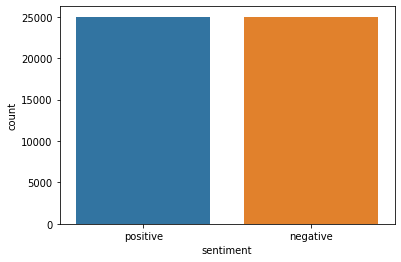

In [50]:
ax=sb.countplot(x='sentiment', data=movie_reviews)
# plt.show()

In [51]:
TAG_RE=re.compile(r'<[^>]+>')

In [52]:
def preprocess_sentence(sent):
    # removing the tags
    sent=TAG_RE.sub("", sent)
    
    # remove punctuations and numbers
    sent=re.sub(r'[^a-zA-Z]', ' ', sent)
    
    # single char removal
    sent=re.sub(r'\s+[a-zA-Z]\s+', ' ', sent)
    
    # removing multiple spaces
    sent=re.sub(r'\s+', ' ', sent)
    
    return sent

In [53]:
X=[]
sentences=list(movie_reviews["review"])

In [54]:
for sen in sentences:
    X.append(preprocess_sentence(sen))

In [55]:
print(X[3])

Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them 


In [56]:
y=movie_reviews['sentiment']
y=np.array(list(map(lambda x:1 if x=="positive" else 0, y)))

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [58]:
tokenizer=Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train=tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)

vocab_size=len(tokenizer.word_index)+1

In [59]:
maxlen=100

X_train=pad_sequences(X_train, padding="post", maxlen=maxlen)
X_test=pad_sequences(X_test, padding="post", maxlen=maxlen)

In [61]:
from numpy import asarray
from numpy import zeros

embeddings_dict=dict()
glove_file=open('glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
    record = line.split()
    word = record[0]
    label= asarray(record[1:], dtype="float32")
    embeddings_dict[word]=label

glove_file.close()

embedding_matrix=zeros((vocab_size, 100))

for word, index in tokenizer.word_index.items():
    embedding_vector=embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index]=embedding_vector

In [74]:
from keras.layers import Conv1D, LSTM

# model = Sequential()
# embedding_layer = Embedding(vocab_size, 100,
# weights=[embedding_matrix], input_length=maxlen,
# trainable=False)
# model.add(embedding_layer)
# model.add(Conv1D(128, 5, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam',
# loss='binary_crossentropy', metrics=['acc'])

model = Sequential()
embedding_layer = Embedding(vocab_size, 100,
weights=[embedding_matrix], input_length=maxlen,
trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
loss='binary_crossentropy', metrics=['acc'])


model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________


In [75]:
history=model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 33s 1ms/step - loss: 0.5530 - acc: 0.7067 - val_loss: 0.4507 - val_acc: 0.7943
Epoch 2/6
32000/32000 [==============================] - 33s 1ms/step - loss: 0.4440 - acc: 0.7903 - val_loss: 0.4321 - val_acc: 0.8048
Epoch 3/6
32000/32000 [==============================] - 33s 1ms/step - loss: 0.3995 - acc: 0.8185 - val_loss: 0.3814 - val_acc: 0.8335
Epoch 4/6
32000/32000 [==============================] - 33s 1ms/step - loss: 0.3717 - acc: 0.8331 - val_loss: 0.3643 - val_acc: 0.8317
Epoch 5/6
32000/32000 [==============================] - 32s 1ms/step - loss: 0.3472 - acc: 0.8471 - val_loss: 0.3459 - val_acc: 0.8518
Epoch 6/6
32000/32000 [==============================] - 33s 1ms/step - loss: 0.3250 - acc: 0.8583 - val_loss: 0.3336 - val_acc: 0.8536


In [76]:
score=model.evaluate(X_test, y_test, verbose=1)
print("test loss: ", score[0])
print("test accuracy: ", score[1])

10000/10000 [==============================] - 19s 2ms/step
test loss:  0.3300992702007294
test accuracy:  0.8514000177383423


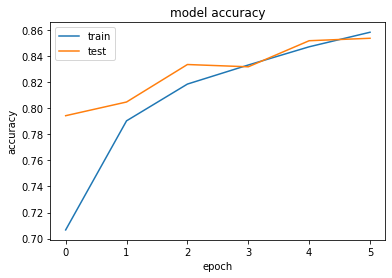

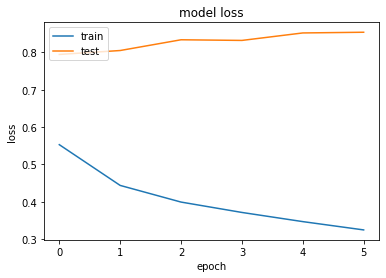

In [82]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_acc'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()